In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import geopandas as gpd
from rasterio.transform import AffineTransformer

In [2]:
from scipy.interpolate import bisplev, bisplrep, interp2d

In [3]:
import plotly

In [9]:
import plotly.graph_objects as go
import tifffile as tiff
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

In [5]:
# yerevan
tin_tif = tiff.imread('../maps_data/output_SRTMGL3.tif')
yerevan_bbox = (44.45334631010809, 40.13452998230207, 44.601379968322625, 40.24853477196325)


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

def extend_line_to_boundaries(start, end, shape):
    """
    Extend a line from start to end points until it hits array boundaries.
    
    Parameters:
    start: (row, col) tuple
    end: (row, col) tuple
    shape: (nrows, ncols) tuple - shape of the array
    
    Returns:
    extended_start, extended_end: tuples of extended coordinates
    """
    rows, cols = shape

    # Direction vector
    dr = end[0] - start[0]
    dc = end[1] - start[1]

    # Normalize direction
    length = np.sqrt(dr**2 + dc**2)
    dr_norm = dr / length
    dc_norm = dc / length

    # Find intersections with all four boundaries
    t_values = []

    # Top boundary (row = 0)
    if dr_norm != 0:
        t = -start[0] / dr_norm
        t_values.append(t)

    # Bottom boundary (row = rows - 1)
    if dr_norm != 0:
        t = (rows - 1 - start[0]) / dr_norm
        t_values.append(t)

    # Left boundary (col = 0)
    if dc_norm != 0:
        t = -start[1] / dc_norm
        t_values.append(t)

    # Right boundary (col = cols - 1)
    if dc_norm != 0:
        t = (cols - 1 - start[1]) / dc_norm
        t_values.append(t)

    # Find the two t values that extend in opposite directions
    t_min = min(t_values)
    t_max = max(t_values)

    # Calculate extended points
    extended_start = (start[0] + t_min * dr_norm, start[1] + t_min * dc_norm)
    extended_end = (start[0] + t_max * dr_norm, start[1] + t_max * dc_norm)

    # Clamp to boundaries
    extended_start = (
        max(0, min(rows - 1, extended_start[0])),
        max(0, min(cols - 1, extended_start[1]))
    )
    extended_end = (
        max(0, min(rows - 1, extended_end[0])),
        max(0, min(cols - 1, extended_end[1]))
    )

    return extended_start, extended_end


# Read the GeoTIFF
with rasterio.open('../maps_data/output_SRTMGL3.tif') as src:
    elevation = src.read(1)
    transform = src.transform
    nodata = src.nodata

    # Mask nodata values if present
    if nodata is not None:
        valid_mask = elevation != nodata
        valid_elevation = np.where(valid_mask, elevation, np.nan)
    else:
        valid_elevation = elevation

    # Find min and max points (ignoring nodata)
    min_idx = np.nanargmin(valid_elevation)
    max_idx = np.nanargmax(valid_elevation)

    # Convert flat indices to 2D coordinates
    min_point = np.unravel_index(min_idx, elevation.shape)  # (row, col)
    max_point = np.unravel_index(max_idx, elevation.shape)

    print(f"Min elevation: {elevation[min_point]:.2f} at pixel {min_point}")
    print(f"Max elevation: {elevation[max_point]:.2f} at pixel {max_point}")

    # Extend line to array boundaries
    start_pixel, end_pixel = min_point, max_point #extend_line_to_boundaries(
        # min_point, max_point, elevation.shape
    # )

    print(f"Extended line from {start_pixel} to {end_pixel}")

    # Generate points along the extended line
    num_points = 1000
    rows = np.linspace(start_pixel[0], end_pixel[0], num_points)
    cols = np.linspace(start_pixel[1], end_pixel[1], num_points)

    # Sample elevation values
    coordinates = np.vstack([rows, cols])
    profile_values = map_coordinates(elevation, coordinates, order=1, cval=np.nan)

    # Convert pixel coordinates to geographic coordinates
    geo_coords = []
    for row, col in zip(rows, cols):
        x, y = rasterio.transform.xy(transform, row, col)
        geo_coords.append((x, y))

    geo_coords = np.array(geo_coords)

    # Calculate distances along profile
    pixel_size_x = abs(transform[0])
    pixel_size_y = abs(transform[4])

    distances = np.zeros(num_points)
    for i in range(1, num_points):
        dx = (cols[i] - cols[i-1]) * pixel_size_x
        dy = (rows[i] - rows[i-1]) * pixel_size_y
        distances[i] = distances[i-1] + np.sqrt(dx**2 + dy**2)

    # Plot the profile
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # Elevation profile
    ax1.plot(distances, profile_values, linewidth=2, color='steelblue')
    ax1.scatter([0], [elevation[min_point]], color='green', s=100,
                label=f'Min: {elevation[min_point]:.1f}m', zorder=5)

    # Find where max point appears in the profile
    max_distance = distances[np.argmin(np.abs(
        (rows - max_point[0])**2 + (cols - max_point[1])**2
    ))]
    ax1.scatter([max_distance], [elevation[max_point]], color='red', s=100,
                label=f'Max: {elevation[max_point]:.1f}m', zorder=5)

    ax1.set_xlabel('Distance along profile (m)', fontsize=12)
    ax1.set_ylabel('Elevation (m)', fontsize=12)
    ax1.set_title('Elevation Profile from Min to Max', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Show the line on the elevation map
    ax2.imshow(elevation, cmap='terrain')
    ax2.plot(cols, rows, 'r-', linewidth=2, label='Profile line')
    ax2.scatter([min_point[1]], [min_point[0]], color='green', s=100,
                marker='o', edgecolor='white', linewidth=2, label='Min', zorder=5)
    ax2.scatter([max_point[1]], [max_point[0]], color='red', s=100,
                marker='o', edgecolor='white', linewidth=2, label='Max', zorder=5)
    ax2.set_xlabel('Column (pixels)', fontsize=12)
    ax2.set_ylabel('Row (pixels)', fontsize=12)
    ax2.set_title('Profile Line Location', fontsize=14)
    ax2.legend()
    ax2.set_aspect('equal')

    plt.tight_layout()
    plt.show()

    # Print some coordinates along the line
    print("\nSample coordinates along the line:")
    print("Distance (m) | Longitude | Latitude | Elevation (m)")
    print("-" * 60)
    for i in range(0, num_points, num_points // 10):
        print(f"{distances[i]:10.1f} | {geo_coords[i, 0]:9.5f} | "
              f"{geo_coords[i, 1]:8.5f} | {profile_values[i]:8.1f}")

    # Save coordinates to file (optional)
    output_data = np.column_stack([
        distances, geo_coords[:, 0], geo_coords[:, 1],
        rows, cols, profile_values
    ])
    np.savetxt('profile_coordinates.csv', output_data,
               delimiter=',',
               header='distance_m,longitude,latitude,row,col,elevation_m',
               comments='')
    print("\nCoordinates saved to 'profile_coordinates.csv'")

In [12]:
transform

Affine(0.000833333333333144, 0.0, 44.452916666615664,
       0.0, -0.000833333333333144, 40.24875000000449)

In [7]:
df = pd.read_csv('profile_coordinates.csv')

In [13]:
from scipy import signal
peaks = signal.find_peaks(df['elevation_m'], prominence=10)[0]

In [23]:
df.iloc[np.concatenate([peaks, [500]])][['distance_m', 'latitude', 'longitude', 'elevation_m']].values

array([[1.60825143e-02, 4.01592618e+01, 4.44707833e+01, 9.19000000e+02],
       [3.95036517e-02, 4.01678954e+01, 4.44925551e+01, 9.77000000e+02],
       [1.03209145e-01, 4.01913789e+01, 4.45517743e+01, 1.23500000e+03],
       [7.80704579e-02, 4.01821121e+01, 4.45284059e+01, 1.03300000e+03]])

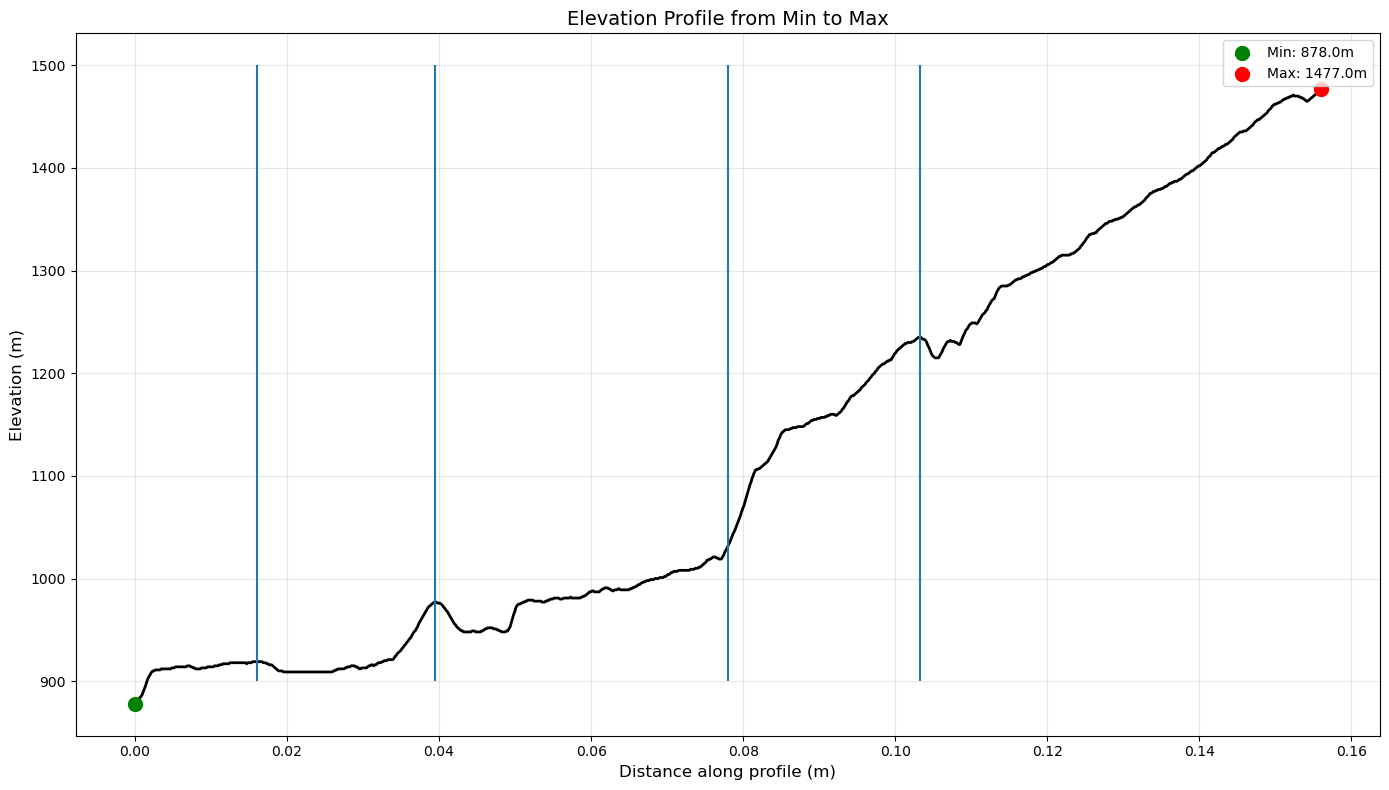

In [22]:
# Plot the profile
fig = plt.figure(figsize=(14, 8))

ax1 = plt.gca()

# Elevation profile
ax1.plot(distances, profile_values, linewidth=2, color='k')
ax1.vlines(distances[peaks], ymin=900, ymax=1500)
ax1.vlines(distances[500], ymin=900, ymax=1500)
ax1.scatter([0], [elevation[min_point]], color='green', s=100, label=f'Min: {elevation[min_point]:.1f}m', zorder=5)

# Find where max point appears in the profile
max_distance = distances[np.argmin(np.abs(
    (rows - max_point[0])**2 + (cols - max_point[1])**2
))]
ax1.scatter([max_distance], [elevation[max_point]], color='red', s=100, label=f'Max: {elevation[max_point]:.1f}m', zorder=5)

ax1.set_xlabel('Distance along profile (m)', fontsize=12)
ax1.set_ylabel('Elevation (m)', fontsize=12)
ax1.set_title('Elevation Profile from Min to Max', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()
# ax1.axis('off')
plt.savefig('profile_lines.png', dpi=300)
plt.tight_layout()
plt.show()

In [31]:
rasterio.transform.rowcol(transform, xs=44.4558333, ys=40.153333)

(np.int32(114), np.int32(3))

In [34]:
transform

Affine(0.000833333333333144, 0.0, 44.452916666615664,
       0.0, -0.000833333333333144, 40.24875000000449)

In [ ]:
# Read the GeoTIFF
with rasterio.open('../maps_data/output_SRTMGL3.tif') as src:
    elevation = src.read(1)
    transform = src.transform
    nodata = src.nodata

    # Mask nodata values if present
    if nodata is not None:
        valid_mask = elevation != nodata
        valid_elevation = np.where(valid_mask, elevation, np.nan)
    else:
        valid_elevation = elevation

    # interesting coordinates (start/end)
    start_crd = (40.20364, 44.51684) #(40.1996848,44.5204815)
    end_crd = (40.169188, 44.513442) #(40.1709023,44.515188)

    start_pixel = rasterio.transform.rowcol(transform, xs=start_crd[1], ys=start_crd[0])
    end_pixel = rasterio.transform.rowcol(transform, xs=end_crd[1], ys=end_crd[0])

    print(f"Profile from {start_pixel} to {end_pixel}")

    # Generate points along the extended line
    num_points = 1000
    rows = np.linspace(start_pixel[0], end_pixel[0], num_points)
    cols = np.linspace(start_pixel[1], end_pixel[1], num_points)

    # Sample elevation values
    coordinates = np.vstack([rows, cols])
    profile_values = map_coordinates(elevation, coordinates, order=1, cval=np.nan)

    # Convert pixel coordinates to geographic coordinates
    geo_coords = []
    for row, col in zip(rows, cols):
        x, y = rasterio.transform.xy(transform, row, col)
        geo_coords.append((x, y))

    geo_coords = np.array(geo_coords)

    # Calculate distances along profile
    pixel_size_x = abs(transform[0])
    pixel_size_y = abs(transform[4])

    distances = np.zeros(num_points)
    for i in range(1, num_points):
        dx = (cols[i] - cols[i-1]) * pixel_size_x
        dy = (rows[i] - rows[i-1]) * pixel_size_y
        distances[i] = distances[i-1] + np.sqrt(dx**2 + dy**2)

    # Plot the profile
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # Elevation profile
    ax1.plot(distances, profile_values, linewidth=2, color='steelblue')
    # ax1.scatter([0], [elevation[min_point]], color='green', s=100, label=f'Min: {elevation[min_point]:.1f}m', zorder=5)

    # Find where max point appears in the profile
    max_distance = distances[np.argmin(np.abs(
        (rows - max_point[0])**2 + (cols - max_point[1])**2
    ))]
    # ax1.scatter([max_distance], [elevation[max_point]], color='red', s=100, label=f'Max: {elevation[max_point]:.1f}m', zorder=5)

    ax1.set_xlabel('Distance along profile (m)', fontsize=12)
    ax1.set_ylabel('Elevation (m)', fontsize=12)
    ax1.set_title('Elevation Profile from Min to Max', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Show the line on the elevation map
    ax2.imshow(elevation, cmap='terrain')
    ax2.plot(cols, rows, 'r-', linewidth=2, label='Profile line')
    ax2.scatter([min_point[1]], [min_point[0]], color='green', s=100,
                marker='o', edgecolor='white', linewidth=2, label='Min', zorder=5)
    ax2.scatter([max_point[1]], [max_point[0]], color='red', s=100,
                marker='o', edgecolor='white', linewidth=2, label='Max', zorder=5)
    ax2.set_xlabel('Column (pixels)', fontsize=12)
    ax2.set_ylabel('Row (pixels)', fontsize=12)
    ax2.set_title('Profile Line Location', fontsize=14)
    ax2.legend()
    ax2.set_aspect('equal')

    plt.tight_layout()
    plt.show()

    # Print some coordinates along the line
    print("\nSample coordinates along the line:")
    print("Distance (m) | Longitude | Latitude | Elevation (m)")
    print("-" * 60)
    for i in range(0, num_points, num_points // 10):
        print(f"{distances[i]:10.1f} | {geo_coords[i, 0]:9.5f} | "
              f"{geo_coords[i, 1]:8.5f} | {profile_values[i]:8.1f}")

    # Save coordinates to file (optional)
    output_data = np.column_stack([
        distances, geo_coords[:, 0], geo_coords[:, 1],
        rows, cols, profile_values
    ])
    # np.savetxt('profile_coordinates.csv', output_data,
    #            delimiter=',',
    #            header='distance_m,longitude,latitude,row,col,elevation_m',
    #            comments='')
    # print("\nCoordinates saved to 'profile_coordinates.csv'")

In [55]:
coordinates[:, 330], rasterio.transform.xy(transform, coordinates[0, 370], coordinates[1, 370]), rasterio.transform.xy(transform, coordinates[0, 220], coordinates[1, 220])

(array([67.54354354, 74.67867868]),
 (np.float64(44.51543209871441), np.float64(40.19067901235018)),
 (np.float64(44.51593259921491), np.float64(40.195809142480314)))

In [6]:
def coords_and_elevation(transform, elevation, rows, cols):
    # Sample elevation values
    coordinates = np.vstack([rows, cols])
    profile_values = map_coordinates(elevation, coordinates, order=1, cval=np.nan)

    # Convert pixel coordinates to geographic coordinates
    geo_coords = []
    for row, col in zip(rows, cols):
        x, y = rasterio.transform.xy(transform, row, col)
        geo_coords.append((x, y))

    geo_coords = np.array(geo_coords)

    # Calculate distances along profile
    pixel_size_x = abs(transform[0])
    pixel_size_y = abs(transform[4])

    distances = np.zeros(len(rows))
    for i in range(1, len(rows)):
        dx = (cols[i] - cols[i-1]) * pixel_size_x
        dy = (rows[i] - rows[i-1]) * pixel_size_y
        distances[i] = distances[i-1] + np.sqrt(dx**2 + dy**2)

    return profile_values, distances, geo_coords

In [25]:
from astropy.coordinates import Angle, SkyCoord
decimal_deg = end_crd[1]

# Create an Angle object
angle = Angle(decimal_deg * u.deg)

# Convert to DMS format (various styles)
dms_string = angle.to_string(unit=u.deg, sep=':', precision=2)
print(f"Decimal: {decimal_deg}°")
print(f"DMS (colon-separated): {dms_string}")

# With different separators
dms_space = angle.to_string(unit=u.deg, sep=' ', precision=2)
print(f"DMS (space-separated): {dms_space}")

# Traditional format with symbols
dms_traditional = angle.to_string(unit=u.deg, sep='dms', precision=2)
print(f"DMS (traditional): {dms_traditional}")

Decimal: 44.513442°
DMS (colon-separated): 44:30:48.39
DMS (space-separated): 44 30 48.39
DMS (traditional): 44d30m48.39s


/var/folders/d6/lx3ld9gd6kg4j1qq4qkztcq80000gn/T/ipykernel_28489/1222356956.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


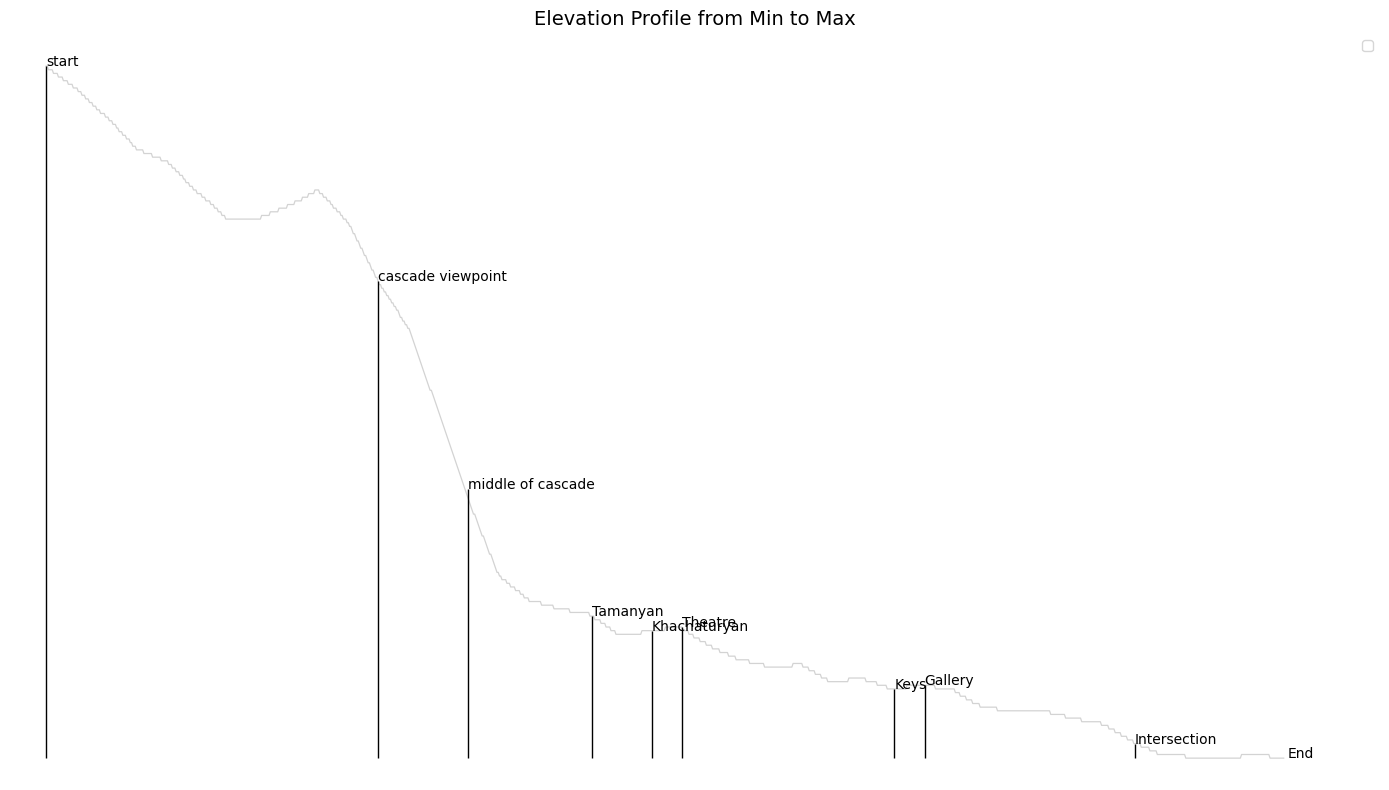

In [26]:
# Read the GeoTIFF
with rasterio.open('../maps_data/output_SRTMGL3.tif') as src:
    elevation = src.read(1)
    transform = src.transform
    nodata = src.nodata

    # Mask nodata values if present
    if nodata is not None:
        valid_mask = elevation != nodata
        valid_elevation = np.where(valid_mask, elevation, np.nan)
    else:
        valid_elevation = elevation

    # interesting coordinates (start/end)
    start_crd = (40.20364, 44.51684) #(40.1996848,44.5204815)
    point1 = (40.194151, 44.515770) # обзорная площадка над каскадом
    point2 = (40.191459, 44.515625) # примерно середина каскада
    point3 = (40.188621, 44.515354) # памятник Таманяну
    point4 = (40.186644, 44.515129) # памтяник Хачатуряну
    point5 = (40.185683, 44.515067) # национальный театр оперы и балета
    point6 = (40.180255, 44.514501) # ключи от Еревана
    point7 = (40.178800, 44.514295) # национальная галерея
    point8 = (40.173315, 44.513783)  # пересечение двух больших трасс
    end_crd = (40.169188, 44.513442) #(40.1709023,44.515188)

    interesting_coordinates = np.vstack([start_crd, point1, point2, point3, point4, point5, point6, point7, point8, end_crd])
    labels = ['start', 'cascade viewpoint', 'middle of cascade', 'Tamanyan', 'Khachaturyan', 'Theatre', 'Keys', 'Gallery', 'Intersection', 'End']

    start_pixel = rasterio.transform.rowcol(transform, xs=interesting_coordinates[0][1], ys=interesting_coordinates[0][0])
    end_pixel = rasterio.transform.rowcol(transform, xs=interesting_coordinates[-1][1], ys=interesting_coordinates[-1][0])

    # Generate points along the extended line
    num_points = 1000
    rows = np.linspace(start_pixel[0], end_pixel[0], num_points)
    cols = np.linspace(start_pixel[1], end_pixel[1], num_points)

    interesting_pixels = rasterio.transform.rowcol(transform, xs=interesting_coordinates[:, 1], ys=interesting_coordinates[:, 0])

    profile_values_all, distances_all, geo_coords_all = coords_and_elevation(transform, elevation, rows, cols)
    profile_values, distances, geo_coords = coords_and_elevation(transform, elevation, interesting_pixels[0], interesting_pixels[1])

    # Plot the profile
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 8))

    # Elevation profile
    ax1.plot(distances_all, profile_values_all, linewidth=0.9, color='lightgrey')
    ax1.vlines(distances, np.ones_like(profile_values)*np.min(profile_values_all), profile_values, linewidth=1., color='k')
    for dist, elev, label in zip(distances, profile_values, labels):
        ax1.annotate(label, (dist, elev))

    ax1.set_xlabel('Distance along profile (m)', fontsize=12)
    ax1.set_ylabel('Elevation (m)', fontsize=12)
    ax1.set_title('Elevation Profile from Min to Max', fontsize=14)
    # ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_ylim(970, 1175)
    ax1.set_xlim(-0.001, 0.037)
    ax1.set_axis_off()
    plt.tight_layout()
    # plt.savefig('only_lines.png', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

    # # Print some coordinates along the line
    # print("\nSample coordinates along the line:")
    # print("Distance (m) | Longitude | Latitude | Elevation (m)")
    # print("-" * 60)
    # for i in range(0, num_points, num_points // 10):
    #     print(f"{distances[i]:10.1f} | {geo_coords[i, 0]:9.5f} | "
    #           f"{geo_coords[i, 1]:8.5f} | {profile_values[i]:8.1f}")
    #
    # # Save coordinates to file (optional)
    # output_data = np.column_stack([
    #     distances, geo_coords[:, 0], geo_coords[:, 1],
    #     rows, cols, profile_values
    # ])
    # np.savetxt('profile_coordinates.csv', output_data,
    #            delimiter=',',
    #            header='distance_m,longitude,latitude,row,col,elevation_m',
    #            comments='')
    # print("\nCoordinates saved to 'profile_coordinates.csv'")


In [20]:
from astropy.coordinates import EarthLocation
import astropy.units as u

# Method 1: Using EarthLocation (most straightforward)
# Define two locations using latitude and longitude
loc1 = EarthLocation.from_geodetic(lon=start_crd[1]*u.deg, lat=start_crd[0]*u.deg)  # New York
loc2 = EarthLocation.from_geodetic(lon=end_crd[1]*u.deg, lat=end_crd[0]*u.deg)  # Los Angeles

# Calculate great circle distance
distance = loc1.separation_3d(loc2)
print(f"3D distance: {distance.to(u.km):.2f}")

# # For surface distance (great circle), use geodetic separation
# # This accounts for Earth's ellipsoidal shape
# from astropy.coordinates import SkyCoord
#
# # Convert to sky coordinates for angular separation
# coord1 = SkyCoord(lon=start_crd[1]*u.deg, lat=start_crd[0]*u.deg, frame='itrs')
# coord2 = SkyCoord(lon=start_crd[1]*u.deg, lat=start_crd[0]*u.deg, frame='itrs')

# Get angular separation and multiply by Earth's mean radius
# angular_sep = coord1.separation(coord2)
# earth_radius = 6371 * u.km  # Mean radius
# surface_distance = angular_sep.radian * earth_radius
#
# print(f"Angular separation: {angular_sep.to(u.deg):.4f}")
# print(f"Surface distance (great circle): {surface_distance:.2f}")
#
# # Method 2: More accurate using the geodetic separation directly
# # For accurate great-circle distance on the surface
# def great_circle_distance(lon1, lat1, lon2, lat2):
#     """
#     Calculate great circle distance using haversine formula via astropy.
#
#     Parameters:
#     lon1, lat1: First point (degrees)
#     lon2, lat2: Second point (degrees)
#
#     Returns:
#     Distance in kilometers
#     """
#     c1 = SkyCoord(lon=lon1*u.deg, lat=lat1*u.deg, frame='itrs')
#     c2 = SkyCoord(lon=lon2*u.deg, lat=lat2*u.deg, frame='itrs')
#
#     angular_distance = c1.separation(c2)
#     earth_mean_radius = 6371.0088 * u.km  # More precise mean radius
#
#     return (angular_distance.radian * earth_mean_radius).to(u.km)
#
# # Example usage
# dist = great_circle_distance(-74.0060, 40.7128, -118.2437, 34.0522)
# print(f"\nGreat circle distance: {dist:.2f}")
#
# # You can also get distance in other units
# print(f"Distance in miles: {dist.to(u.imperial.mile):.2f}")
# print(f"Distance in meters: {dist.to(u.m):.0f}")

AttributeError: 'EarthLocation' object has no 'separation_3d' member

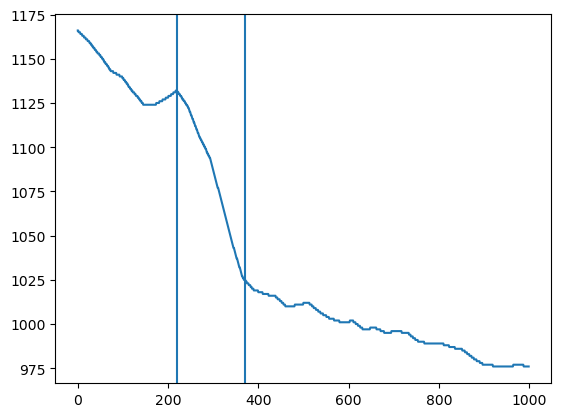

In [56]:
plt.plot(profile_values)
plt.axvline(370)
plt.axvline(220)

In [159]:
# tin_tif = tiff.imread('shiprock.tin.tif')

In [6]:
Xmin = -12120549.333731556
Xmax = -12114597.210704293
Ymin = 4394825.692296092
Ymax = 4396833.09735777

In [7]:
tin_tif[np.where(tin_tif == -9999.)] = 1400

In [171]:
tin_tif.max(), tin_tif.min()

(1477, 878)

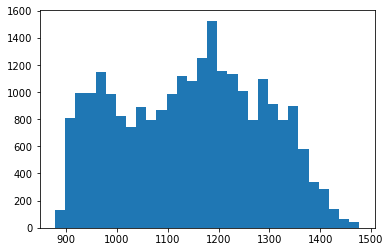

In [160]:
plt.figure()
plt.hist(tin_tif.ravel(), bins=30)
plt.show()

In [161]:
tin_tif.shape

(137, 178)

In [162]:
fig = go.Figure()
fig.add_trace(go.Surface(z=tin_tif[::2, ::3]))
fig.write_html("test_yerevan.html")

In [11]:
from ridge_map import RidgeMap
import matplotlib.pyplot as plt

In [12]:
# Define the bounding box coordinates for Mt. Shasta
mt_shasta_bbox = (-122.5, 41.25, -122.0, 41.5)

In [165]:
rm = RidgeMap(yerevan_bbox)
# rm = RidgeMap(mt_shasta_bbox)

In [29]:
tin_tif[::2, ::3].shape

(856, 1605)

In [34]:
from scipy.ndimage import rotate

In [166]:
values = rm.get_elevation_data(num_lines=150)

4 2884802


In [167]:
values.shape

(150, 300)

In [168]:
values = rm.preprocess(values=values, #tin_tif[::10, ::3],
                       lake_flatness=.9,
                       water_ntile=10,
                       vertical_ratio=500)

In [132]:
values = rotate(values, angle=5, reshape=False, order=0)

In [133]:
np.nanmin(values)

0.0

In [134]:
# values[np.isnan(values)] = 0

In [152]:
values.shape

(172, 1605)

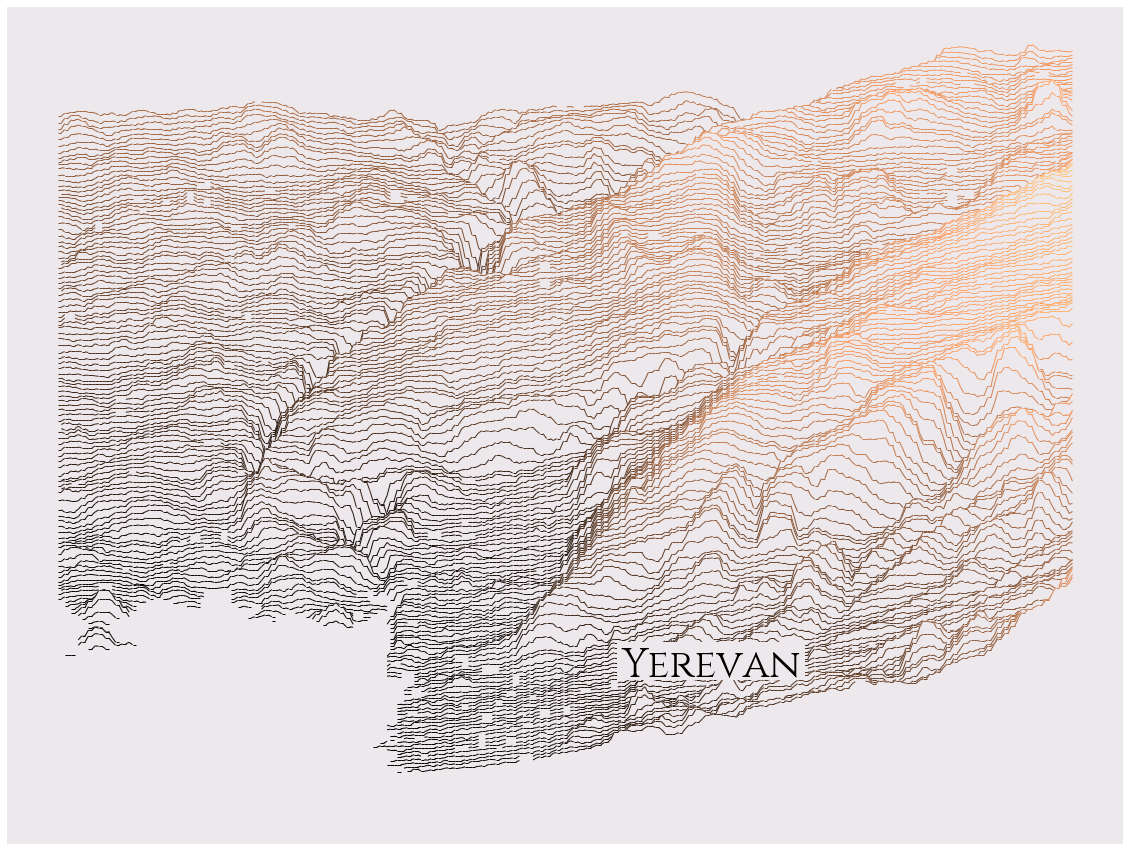

In [169]:
fig = rm.plot_map(values=values[:, :],
            label='Yerevan',
            label_y=0.2,
            label_x=0.55,
            label_size=40,
            linewidth=1,
            line_color=plt.get_cmap('copper'),
            kind='elevation')
# plt.savefig('shiprock.png', dpi=300, bbox_inches='tight')

<AxesSubplot:>

In [ ]:
elevation_map = np.loadtxt('point_reyes_las_1_23.txt')

In [ ]:
Xmin_origin = -13675652.648650572
Ymin_origin = 4571407.5985559635
Xmax_origin = -13666438.362932276
Ymax_origin = 4585619.858742765

In [ ]:
elevation_map_short = elevation_map[:]

In [ ]:
elevation_map_short.shape

In [ ]:
elevation_map_short[:, 1].max() - elevation_map_short[:, 1].min(), Ymax_origin - Ymin_origin

In [ ]:
from scipy.interpolate import griddata

xin=elevation_map_short[:, 0] - elevation_map_short[:, 0].min() + Xmin_origin
yin=elevation_map_short[:, 1] - elevation_map_short[:, 1].min() + Ymin_origin
zin=elevation_map_short[:, 2]
 
xout=np.linspace(xin.min(), xin.max(), 500);
yout=np.linspace(yin.min(), yin.max(), 500);
xout,yout = np.meshgrid(xout,yout);

zout=griddata((xin,yin),zin,(xout,yout),'nearest')

In [ ]:
xin

In [ ]:
zout.max(), np.percentile(zout[400:600, 400:600], 96)

In [ ]:
zout[np.where(zout > 200)] = zout.min()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Surface(z=zout))
fig.write_html("test_point_reyes.html")

In [ ]:
day1_df = pd.read_csv('Day_1.csv')
gdf_1 = gpd.GeoDataFrame(day1_df, geometry=gpd.GeoSeries.from_xy(day1_df['lng'], day1_df['lat']), crs=4326).to_crs('EPSG:3857')

day1_df = pd.read_csv('Day_2.csv')
gdf_2 = gpd.GeoDataFrame(day1_df, geometry=gpd.GeoSeries.from_xy(day1_df['lng'], day1_df['lat']), crs=4326).to_crs('EPSG:3857')

day1_df = pd.read_csv('Day_3.csv')
gdf_3 = gpd.GeoDataFrame(day1_df, geometry=gpd.GeoSeries.from_xy(day1_df['lng'], day1_df['lat']), crs=4326).to_crs('EPSG:3857')

In [ ]:
plt.figure()
# plt.imshow(zout, extent=[Xmin_origin, Xmax_origin, Ymin_origin, Ymax_origin], origin='lower')
gdf_1.plot(ax=plt.gca(), lw=0.1)
gdf_2.plot(ax=plt.gca(), lw=0.1)
gdf_3.plot(ax=plt.gca(), lw=0.1)
plt.show()

In [ ]:
d1_crd = np.stack([gdf_1.geometry.x,gdf_1.geometry.y]).T
d2_crd = np.stack([gdf_2.geometry.x,gdf_2.geometry.y]).T
d3_crd = np.stack([gdf_3.geometry.x,gdf_3.geometry.y]).T

In [ ]:
np.min(np.concatenate([d1_crd[:, 0], d2_crd[:, 0], d3_crd[:, 0]])), np.max(np.concatenate([d1_crd[:, 0], d2_crd[:, 0], d3_crd[:, 0]])), np.min(np.concatenate([d1_crd[:, 1], d2_crd[:, 1], d3_crd[:, 1]])), np.max(np.concatenate([d1_crd[:, 1], d2_crd[:, 1], d3_crd[:, 1]]))

In [ ]:
plt.figure()
plt.imshow(zout, extent=[Xmin_origin, Xmax_origin, Ymin_origin, Ymax_origin], origin='lower')
plt.scatter(d1_crd[:, 0], d1_crd[:, 1], c=griddata((xin,yin),zin,d1_crd,'nearest'), s=1.)
plt.scatter(d2_crd[:, 0], d2_crd[:, 1], c=griddata((xin,yin),zin,d2_crd,'nearest'), s=1.)
plt.scatter(d3_crd[:, 0], d3_crd[:, 1], c=griddata((xin,yin),zin,d3_crd,'nearest'), s=1.)
plt.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Surface(x=xout, y=yout, z=zout))

for df in [d1_crd, d2_crd, d3_crd]:
    z_data = griddata((xin,yin),zin,df,'nearest')
    fig.add_trace(go.Scatter3d(x=df[:, 0], y=df[:, 1], z=z_data, mode='markers', marker=dict(size=5, color='lawngreen', opacity=.3), showlegend=False,))

fig.update_layout(scene_aspectmode='manual',
                  scene_aspectratio=dict(x=1, y=1, z=0.2))
fig.write_html("point_reyes_3d_test_scatter.html")

In [ ]:
xout.max()-xout.min()

In [ ]:
traceS=dict(type='surface',
            x=xout,
            y=yout,
            z=zout,
            showscale=True,
            colorbar=dict(thickness=20, ticklen=4)
            )

In [ ]:
axis = dict(showbackground=True,
            backgroundcolor="rgb(230, 230,230)",
            gridcolor="rgb(255, 255, 255)",
            zerolinecolor="rgb(255, 255, 255)",
            )



layout = dict(title='Point Reyes',
              width=800,
              height=650,
              scene=dict(xaxis=axis,
                         yaxis=axis,
                         zaxis=axis,
                         aspectratio=dict(x=1,
                                          y=1,
                                          z=0.85
                                          )
                         )
              )

In [ ]:
fig = go.Figure()

In [ ]:
fig.add_trace(go.Scatter3d(x=elevation_map[:, 0], y=elevation_map[:, 1], z=elevation_map[:, 2], mode='markers', marker=dict(size=10, color=elevation_map[:, 2], opacity=.3), showlegend=False, ))

In [ ]:
fig.write_html("point_reyes_3d_test.html")